# Continuous Control Project 2

---

Second hands-on project of the Deep Reinforcement Learning Nanodegree.

Note: as mentioned as a tip by the course leader the code is oriented by the solutions teached during the drl - nanodegree.

### 1. Start the Environment
Importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import sys
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Define Agent and Traning

#### Model
The main model behind the ddpg is an actor - critic architecture. You can define the agents NN by setting the input_size, hidden_layers and output_size. The definition for hidden_layers, e.g. hidden_layers=[10, 12], will be interpreted as two (2) hidden layers with 10 respectively 12 neurons (a default hidden_layers=[256, 128] is set if given hidden_layers=None).

By definition the code below will produce a fully connected forward network with a relu activation function between the layers for Actor and Critic.

The Actor - Network has a tanh activation function for the output layer. This correlates with the requirements of the environment for the action vector (must be a number between -1 and 1).

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers=None):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_layers (array): Number of hidden layers and nodes
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        if hidden_layers is None:
            hidden_layers = [256, 128]
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        # Add the last layer, hidden layer to a output
        self.output = nn.Linear(hidden_layers[-1], action_size)
        self.reset_parameters()

    def reset_parameters(self):
        """Reset and initilize nodes for each layer"""
        for linear in self.hidden_layers:
            linear.weight.data.uniform_(*hidden_init(linear))
        self.output.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions. Forward through each layer in `hidden_layers`,
            with ReLU activation
        """
        for linear in self.hidden_layers:
            state = F.relu(linear(state))
        state = self.output(state)
        return torch.tanh(state)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers=None,):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_layers (array): Number of hidden layers and nodes
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        if hidden_layers is None:
            hidden_layers = [256, 128]
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        first_hidden_layer = True
        for h1, h2 in layer_sizes:
            if first_hidden_layer:
                self.hidden_layers.extend([nn.Linear(h1+action_size, h2)])
                first_hidden_layer = False
            else:
                self.hidden_layers.extend([nn.Linear(h1, h2)])
        # Add the last layer, hidden layer to a output
        self.output = nn.Linear(hidden_layers[-1], 1)
        self.reset_parameters()

    def reset_parameters(self):
        """Reset and initilize nodes for each layer"""
        for linear in self.hidden_layers:
            linear.weight.data.uniform_(*hidden_init(linear))
        self.output.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values. Forward through each layer in
        `hidden_layers`, with ReLU activation.
        """

        first_hidden_layer = True
        for linear in self.hidden_layers:
            state = F.relu(linear(state))
            if first_hidden_layer:
                state = torch.cat((state, action), dim=1)
                first_hidden_layer = False
        return self.output(state)


#### Agent
Define a DDPG - Agent with target network and soft-update for actor and critic networks. The  **kwargs are used to overwrite agents defaults for:
 + BATCH_SIZE = 128
 + BUFFER_SIZE = int(1e5)
 + GAMMA = 0.99
 + LR_ACTOR = 1e-3
 + LR_CRITIC = 1e-3
 + TAU = 1e-3
 + SIGMA = 0.2

If cuda is available, the agent will try to prefer cuda over cpu for training. Parameter for soft update is given by the hyperparameter "TAU". The Exploration-Exploitation problem is addressed by the Ornstein-Uhlenbeck process (for additional action noise). Parameter SIGMA is used to weight the additional noise.

As optimizer the SGD - Adam optimizer (with momentum) is used for better performance.

In [3]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 1e-3              # for soft update of target parameters
SIGMA = 0.2             # Exploration Parameter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, hidden_layers_actor=None, hidden_layers_critic=None, **kwargs):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            hidden_layers_actor (array): define number of actors hidden layers and neurons
            hidden_layers_critic (array): define number of critics hidden layers and neurons
            **kwargs (dict): overwrite default hyperparameter
        """
        self.state_size = state_size
        self.action_size = action_size
        #self.num_agents = num_agents
        self.seed = random.seed(seed)

        #key word arguments
        # BATCH_SIZE
        self.batch_size = BATCH_SIZE
        if 'BATCH_SIZE' in kwargs:
            self.batch_size = kwargs['BATCH_SIZE']
        # BUFFER_SIZE
        self.buffer_size = BUFFER_SIZE
        if 'BUFFER_SIZE' in kwargs:
            self.buffer_size = kwargs['BUFFER_SIZE']
        # Gamma
        self.gamma = GAMMA
        if 'GAMMA' in kwargs:
            self.gamma = kwargs['GAMMA']
        # Tau
        self.tau = TAU
        if 'TAU' in kwargs:
            self.tau = kwargs['TAU']
        # Sigma
        self.sigma = SIGMA
        if 'SIGMA' in kwargs:
            self.sigma = kwargs['SIGMA']

        # Actor Network (w/ Target Network)
        # Learning Rate
        self.lr_actor = LR_ACTOR
        if 'LR_ACTOR' in kwargs:
            self.lr_actor = kwargs['LR_ACTOR']
        # Layer
        if hidden_layers_actor is None:
            hidden_layers_actor = [256, 128]
        self.actor_local = Actor(state_size, action_size, seed, hidden_layers_actor).to(device)
        self.actor_target = Actor(state_size, action_size, seed, hidden_layers_actor).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr_actor)

        # Critic Network (w/ Target Network)
        # Learning Rate
        self.lr_critic = LR_CRITIC
        if 'LR_CRITIC' in kwargs:
            self.lr_critic = kwargs['LR_CRITIC']
        # Layer
        if hidden_layers_actor is None:
            hidden_layers_critic = [256, 128]
        self.critic_local = Critic(state_size, action_size, seed, hidden_layers_critic).to(device)
        self.critic_target = Critic(state_size, action_size, seed, hidden_layers_critic).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.lr_critic)

        # Noise process
        self.noise = OUNoise(action_size, seed, sigma=self.sigma)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.memory.add(state, action, reward, next_state, done)
        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


#### Training and Results
A function to plot the scores (in blue) and optional average scores (in red) over episodes with (inline) matplotlib.

The learning algorithm to train the DDPG Agent is realized with an Ornstein-Uhlenbeck process to define the exploration-exploitation during training. The ddpg-training function is set with parameters to define the training and the monitoring.

In [4]:
def plot_scores(scores, scores_avg=None):
    """Plot scores ans average (option).

    Params
    ======
        scores (array): List of Rewards per Episode
        scores_all_avg (array): List of moving average of reward per Episode
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    if not scores_avg == None:
        plt.plot(np.arange(len(scores)), scores, label='Scores', color='blue')
        plt.plot(np.arange(len(scores_avg)), scores_avg, label='Average', color='red')
        # show a legend on the plot
        plt.legend()
    else:
        plt.plot(np.arange(len(scores)), scores)
    plt.show()


def ddpg(env, brain_name, agent, num_agents=1, n_episodes=1000, queue=100, print_every=100, stop_solved=30.0, chkpoint_name='checkpoint.pth'):
    """Train DDPG Agent.

    Params
    ======
        env (object): Reacher Environment
        brain_name (object): Env brain name
        agent (object): DDPG Agent
        num_agents (int): Number of agent in environment
        n_episodes (int): Number of episodes
        queue (int): window for monitoring purposes. Defines the rewards average
        print_every (int): parameter for fixed print information in terminal
        stop_solved (float): mean reward over specific windows size to achieve, defined by parameter queue
        chkpoint_name (string): suffix for checkpoint names for critic_* and actor_* checkpoint

    Return
    ======
        scores_all (array): List of Rewards per Episode
        scores_all_avg (array): List of moving average of reward per Episode over window size defined by parameter "queue"
    """
    scores_window = deque(maxlen=queue)
    scores_all = []
    scores_all_avg = []
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        agent.reset()  # reset agents exploration weights
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        while True:
            actions = agent.act(states)  # select an action (for each agent)
            actions = np.clip(actions, -1, 1)  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)  # Save and learn
            scores += rewards  # update the score (for each agent)
            states = next_states  # roll over states to next time step
            if np.any(dones):  # exit loop if episode finished
                break

        scores_window.append(np.mean(scores))
        scores_all.append(np.mean(scores))
        scores_all_avg.append(np.mean(scores_window))
        print('\rEpisode {}\tReward: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores),
                                                                           np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tReward: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores),
                                                                               np.mean(scores_window)))
        if np.mean(scores_window) >= stop_solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor_'+chkpoint_name)
            torch.save(agent.critic_local.state_dict(), 'critic_'+chkpoint_name)
            break
    return scores_all, scores_all_avg


### 3. Train Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac (like i did), then you downloaded `Reacher.app`. If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

After the environment is loaded environments **Brain** has to be defined. Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
env = UnityEnvironment(file_name='Reacher.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


###  Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

In the last code cell some information about the environment are printed.



Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

###### Start Training:

The next code cell will define an DDPG-Agent and the training environment.
 + hidden_layers_actor = [256, 128, 64]  # 3 Hidden layers with 256, 128 and 64 neurons.
 + hidden_layers_critic = [256, 128]     # 2 Hidden layers with 256 and 128 neurons.
 + BATCH_SIZE = 66
 + BUFFER_SIZE = int(1e6)
 + GAMMA = 0.99
 + LR_ACTOR = 1e-3
 + LR_CRITIC = 1e-4
 + TAU = 1e-3
 + SIGMA = 0.15

The training is set to max. 1000 episodes (eps) and will stop if the average reward will hit ">= 30" (stop_solved).
The task is episodic, and in order to solve the environment, the agent must get an average score of +30 over 100 consecutive episodes.

Results for the defined agent are plotted below the code cell as well ass the number of episodes needed to solve the environment.


#### Start training with '1' agent(s) ####
Episode 10	Reward: 1.94	Average Score: 1.22
Episode 20	Reward: 5.00	Average Score: 1.82
Episode 30	Reward: 1.81	Average Score: 1.94
Episode 40	Reward: 6.07	Average Score: 2.49
Episode 50	Reward: 4.60	Average Score: 2.94
Episode 60	Reward: 7.01	Average Score: 3.676
Episode 70	Reward: 10.76	Average Score: 4.26
Episode 80	Reward: 14.52	Average Score: 5.07
Episode 90	Reward: 13.01	Average Score: 6.14
Episode 100	Reward: 22.19	Average Score: 7.33
Episode 110	Reward: 28.25	Average Score: 9.17
Episode 120	Reward: 23.38	Average Score: 11.20
Episode 130	Reward: 29.53	Average Score: 13.65
Episode 140	Reward: 30.86	Average Score: 16.29
Episode 150	Reward: 36.74	Average Score: 19.05
Episode 160	Reward: 32.63	Average Score: 21.46
Episode 170	Reward: 33.54	Average Score: 23.92
Episode 180	Reward: 36.44	Average Score: 25.98
Episode 190	Reward: 37.36	Average Score: 28.05
Episode 200	Reward: 32.96	Average Score: 29.57
Episode 203	Reward: 29.94	Average Score: 

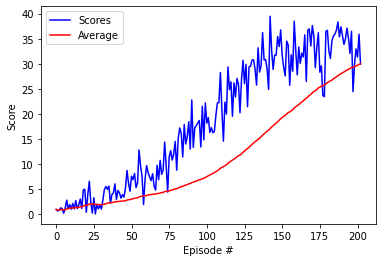

In [6]:
seed_ = 0
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
state = env_info.vector_observations[0]  # test set of environments states
state_size = state.size  # num states
action_size = brain.vector_action_space_size  # num actions
num_agents = len(env_info.agents)
hidden_layers_actor = [256, 128, 64]
hidden_layers_critic = [256, 128]
eps = 1000
date = 20210603
suffix = 'SOLVED'
chkpoint_name = "checkpoint_{}_{}_{}_{}.pth".format(num_agents, eps, date, suffix)
print("\n#### Start training with '{}' agent(s) ####".format(num_agents), end="\n")
sys.stdout.flush()
agent = Agent(state_size=state_size, action_size=action_size, seed=seed_,
                  hidden_layers_actor=hidden_layers_actor, hidden_layers_critic=hidden_layers_critic,
                  **{"BATCH_SIZE": 66, "BUFFER_SIZE": int(1e6), "GAMMA": 0.99, "LR_ACTOR": 1e-3, "LR_CRITIC": 1e-4,
                     "TAU": 1e-3, "SIGMA": 0.15})
scores, scores_avg = ddpg(env, brain_name, agent, num_agents=num_agents, n_episodes=eps, print_every=10,
                                stop_solved=30.0,
                                chkpoint_name=chkpoint_name)
# plot the scores
plot_scores(scores, scores_avg)

### 4. Watch your trained Agent
Load your saved checkpoints or use the trained weights and watch the agent acting in the environment.

In [7]:
# Uncomment if you want to load your checkpoints
#agent.actor_local.load_state_dict(torch.load('actor_' + chkpoint_name))
#agent.critic_local.load_state_dict(torch.load('critic_' + chkpoint_name))

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

for i in range(500):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    if np.any(dones):
        break

### 5. Finish
When finished, you can close the environment by running the following command.

In [8]:
env.close()

### Ideas for Future Work

There are a lot of improvements to make. Some of them are:
 + Add parameter noise for exploration
 + Add batch normalization to improve learn performance
 + prioritized experience replay
 + Improve code to run with multiple reacher - agents
 + Run a empirical case study for hyperparameter alpha (LR - learning Rate) for actor and critic and tau ( for softupdate ) to improve performance.